# <a id="title">`grep`ing 1 GB+ wikiversity-pages </a>


| **[`wikiversity`](#wikiversity)**<br>
| **[`SCOPE`](#scope)**<br>
| **[`IMPLEMENTATION`](#implementation)** *[[How much data to scan?](#totallines)] <sup>[lazy-processing](#singleprocess), [multi-processing](#multiprocess)</sup>, [[Performance](#countingperformance)], [[`grep`'ing a target word](#greponeword)], [[Saving to CSV](#savingresults)]*<br>
| **[`CONCLUSION`](#conclusion)**<br>
| **[`REFERENCES`](#references)**<br>


<br><br>

## <a id="wikiversity">[`wikiversity`](https://www.wikipedia.org/)</a>


Now first, who hasn't heard of [`wikipedia`](https://www.wikipedia.org/)? <sup>It is hosted by [`Wikimedia Foundation`](https://wikimediafoundation.org/) that also sponsors a host of other wikimedia projects like wikiversity, wiktionary, wikibooks, and many others.</sup>
<br>If you haven't, you will know it from now on. It's an expansive tome of crowd-sourced information maintained by volunteer contributors and editors. Anyone knowledgeable can contribute to wiki. Me, you, anyone who wishes to volunteer!


I did mention wiki is an ever-growing expansive tome of innumerous articles!
<br>If you think of each of wikis as an iceberg, I will be using just a tiny set of it's data. For this project purpose, I have randomly scraped articles from [`wikiversity`](https://en.wikiversity.org) in english worth over a GB (1 giga-bytes), all under a single `wikiversity` directory. They are saved as-is (raw html).

Files were saved with the names at the end of the URL.
<br>For example, if the URL is https://en.wikiversity.org/wiki/Big_Data/MapReduce, the article would be saved as MapReduce.html for simplicity.

You might now be wondering what is `grep`ing? I will introduce it as you go through this page. For now, it's enough to know that it means searching in simple terms.
<br>

In [1]:
python_version = !python --version

print(f"{python_version[0]} is in use.", end='\n\n')

Python 3.9.0 is in use.



In [2]:
data_folder = "wikiversity"

!ls -lh {data_folder} > out.txt && head -n 1 < out.txt

total 1.1G


<br>1.1GB is comprised of about 20K files.

In [3]:
!ls {data_folder} | wc -l

20112


<br><br>

## <a id="scope"> SCOPE </a>
The scope of this project is limited to simulating one small functionality of UNIX's `grep` utility.
<br>What is `grep`?

In [4]:
!man grep > out.txt && head -n 15 < out.txt | tail -n 5

DESCRIPTION
       grep  searches  for  PATTERNS  in  each  FILE.  PATTERNS is one or more
       patterns separated by newline characters, and  grep  prints  each  line
       that  matches a pattern.  Typically PATTERNS should be quoted when grep
       is used in a shell command.


More specifically, I will build on the functionality to search for the word in `wikiversity` folder including its location in the file (say, the line number).

<br><br>

## <a id="implementation"> IMPLEMENTATION </a>
You will be wondering how to search from such a huge input of files worth over 1+ GB?

From what I'm aware of, there are two approaches to it:
1. <a id="singleprocess"> [Single process](#countingwithsingleprocess)</a> (*it is sequential and slower*) which I like to term ***lazy-processing***.
2. <a id="multiprocess"> [Multiple processes](#countingwithmultipleprocesses)</a> (this takes advantage of python's concurreny by forking multiple processes, and finally merging results) using [MapReduce](https://en.wikipedia.org/wiki/MapReduce) framework.
<br>***Since mimicking grep's functionality is a `search` operation that is `CPU-intensive`, I will use python's `multiprocessing` framework.***

<br>I will use both the options and plot to reveal how ***multiprocessing can empower***.
<br>In addition, I will be deciding on how many cores to use based on how many processors my machine is equipped with. I will time processing times in each step. This will aid me choosing the optimal number of processes for multiprocessing.


<br>

## <a id="totallines"> So, how much data to scan? </a>
To give you a taste of how many lines will be searched in this 1+ GB worth of scraped data, I will implement a couple of helper functions. Feel free to skip straight to the plot for a complete visual.

In [5]:
import os
from time import time


# List of file names from data directory
file_names = os.listdir(data_folder)

print(f"---- Sample files from the directory ----")
for _ in range(4):
    print(_+1, file_names[_])

# Access the first file from the listing
with open(os.path.join(data_folder, file_names[0])) as file:
    lines = file.readlines()

print()
print(f"---- Sample content of {file_names[0]} ----")
for line in lines[:5]:
    print(line, end="")


print()

---- Sample files from the directory ----
1 $100_bill.html
2 $10_bill.html
3 $1_bill.html
4 $50_bill.html

---- Sample content of $100_bill.html ----
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>United States currency/$100 bill - Wikiversity</title>



In [6]:
# Track number of process workers and their combined performance
process_performance = {}

<br>

### <a id="countingwithsingleprocess"> *Counting with a single process* </a>

In [7]:
# Using a single process (no multiprocessing involved here!)

total_lines = []

start = time()
for file_name in file_names:
    with open(os.path.join(data_folder, file_name), 'rb') as file:
        total_lines.append(len(file.readlines()))
end = time()


process_performance[1] = round(end-start, 3)
print(f"Counted {sum(total_lines):,} lines in a single process in {end-start:.3f}s")

Counted 11,201,390 lines in a single process in 446.446s


<br>

### <a id="countingwithmultipleprocesses"> *Counting with multiple processes* </a>

In [8]:
# Heart of multiprocessing

from math import ceil
from functools import reduce
from multiprocessing import Pool


def data_chunkify(data, number_of_chunks):
    """Split data into chunks suitable for concurrency.
       return: tuple-generator object that generates values on the fly
               instead of passing a huge list of values.
    """
    chunk_size = ceil(len(data) / number_of_chunks)
    return (tuple(data[i:i+chunk_size]) for i in range(0, len(data), chunk_size))

def map_reduce(data, num_of_workers, mapper, reducer):
    """MapReduce forks processes to process data chunks concurrently"""
    chunks = data_chunkify(data, number_of_workers)
    with Pool(processes=number_of_workers) as pool:
        chunk_results = pool.map(mapper, chunks)
    return reduce(reducer, chunk_results)


<br>Note the use of **rb** mode in reading files, below.
<br>
<br>No need to encode because the purpose is just to count total lines.
<br>No need to worry about the exact encoding as some web-scraped files are encoded in a different format.

In [9]:
# Map+Reduce target functions to count total lines that will be scanned for "grep"ing

def mapper_line_count(file_names_chunk):
    """Mapping function to count lines
       Actual total lines that will be scanned"""
    line_count = []
    for file_name in file_names_chunk:
        with open(os.path.join(data_folder, file_name), 'rb') as file:
            line_count.append(len(file.readlines()))
    return sum(line_count)

def reducer_line_count(line_count_1, line_count_2):
    """Reducer function to merge total lines
       Combined actual total lines that will be scanned"""
    return line_count_1 + line_count_2


In [10]:
# Logical processors my local setup provides
number_of_workers = os.cpu_count()

print(f"Local setup is equipped with {number_of_workers} logical processors.")
print()


Local setup is equipped with 8 logical processors.



In [11]:
# Using 2 processes..
number_of_workers = 2

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 54.611s with 2 processes.



In [12]:
# Using 3 processes..
number_of_workers = 3

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 52.982s with 3 processes.



In [13]:
# Using half its capacity: 4 processes..
number_of_workers = 4

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 48.705s with 4 processes.



In [14]:
# Using 5 processes..
number_of_workers = 5

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 35.694s with 5 processes.



In [15]:
# Using 6 processes..
number_of_workers = 6

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 39.177s with 6 processes.



In [16]:
# Using 7 processes..
number_of_workers = 7

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 16.001s with 7 processes.



In [17]:
# Using 8 processes my local setup provides..
number_of_workers = os.cpu_count()

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 31.530s with 8 processes.



In [18]:
# I will double its capacity assuming I'm unaware of local setup: 16 processes
number_of_workers = 16

start = time()
total_lines = map_reduce(file_names, number_of_workers, mapper_line_count, reducer_line_count)
end = time()

process_performance[number_of_workers] = round(end-start, 3)
print(f"Counted {total_lines:,} lines in {end-start:.3f}s with {number_of_workers} processes.")
print()


Counted 11,201,390 lines in 37.517s with 16 processes.



<br>

### <a id="countingperformance"> Counting lines : Performance </a>
Here's a picture of their performance:

In [29]:
import matplotlib.pyplot as plt


def plot(data,
         figsize,
         title,
         legend,
         xlabel,
         ylabel):
    
    plt.style.use("seaborn-poster")
    fig = plt.figure(figsize=figsize)
    
    plt.plot(data.keys(),
             [round(d,1) for d in data.values()],
             'ro',
             markersize=12,
             label=legend)
    plt.xlim(min(data)-1, max(data)+1)
    plt.ylim(0, round(max(data.values())))
    plt.xlabel(xlabel, fontsize=12, color='gray', labelpad=10)
    plt.ylabel(ylabel, fontsize=12, color='gray')
    
    ax = fig.get_axes()[0]
    [ax.spines[spine].set_visible(True if spine == 'bottom' else False) for spine in ax.spines]

    ax.set_xticks([0] + list(data))

    y_max = ax.get_yticks()[-1]
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])

    ax.axhline(min(data.values()), linewidth=1.5, color='red', alpha=0.7)
    ax.text(1+0.2, max(data.values())-20, '$single$ $process$', color='gray', fontsize=10)
    ax.text(11, min(data.values())+5, '$good$ $performance$', color='gray', fontsize=12)
    for x, y in data.items():
        ax.axvline(x,
                   ymin=0,
                   ymax=y/y_max,
                   linewidth=1.7,
                   color=('blue' if y < max(data.values()) else 'gray'),
                   dashes=(1,1))
        ax.text(x+0.15, y+8 if y < 100 else y-5, f"{y:.1f}")

    plt.title(title, fontsize=20, fontweight="bold", pad=10)
    ax.legend(edgecolor='white', fontsize=10)

    plt.show()


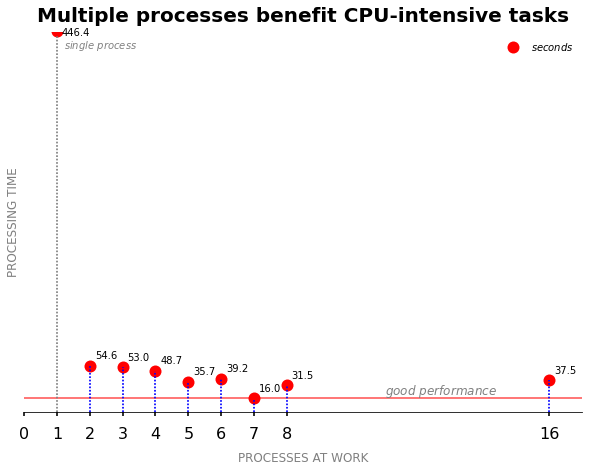

In [30]:
print()

plot(process_performance,
     figsize=(10,7),
     title="Multiple processes benefit CPU-intensive tasks",
     legend="$seconds$",
     xlabel="PROCESSES AT WORK",
     ylabel="PROCESSING TIME");


As you can see, using multiple processes can cut down processing time by atleast 8 - 27 times over a single process.

<br>***Although my local setup provides upto 8 logical cores/processors, I feel it's pointless to use processes beyond 8 as it only adds to memory overhead as the states of each process needs to be maintained.***

<br><br>

## <a id="greponeword"> `grep`'ing a target word </a>
In this section, I will be implementing a **case-insensitive 1-word search** that tracks the line numbers in the file where the matches were found.

In [31]:
# Search word
grep_word = rb'uNITEd StATEs OF AMeriCa'

# Search results dictionary 
grep_result = {}


<br>Note the use of **rb** mode in reading files in this scenario as well.
<br>
<br>No need to encode because **re** module provides a cool feature to compile the search string into bytes which can be used to search directly in a bytes object (in this case, the file contents).

In [32]:
# Map+Reduce target functions for word search

import re
from collections import ChainMap


grep_word_compiled = re.compile(grep_word, re.I)
grep_newline = re.compile(rb'\n')


def mapper_grep_word(file_names_chunk):
    """Mapping function for word search"""
    result_dict = {}
    for file_name in file_names_chunk:
        with open(os.path.join(data_folder, file_name), 'rb') as file:
            file_read = file.read()
            match = tuple(fi.start() for fi in re.finditer(grep_word_compiled, file_read))
            if match:
                result_dict[file_name] = tuple(len(re.findall(grep_newline, file_read[:index_end])) 
                                               for index_end in match)
    return result_dict

def reducer_grep_word(grep_result_1, grep_result_2):
    """Reducer function for word search"""
    return ChainMap(grep_result_1, grep_result_2)


In [33]:
# Using optimal number of processes based on the first graph..
process_performance_T = {t: p for p, t in process_performance.items()}
number_of_workers = process_performance_T[min(process_performance_T)]


start = time()
grep_result = map_reduce(file_names, number_of_workers, mapper_grep_word, reducer_grep_word)
end = time()


# process_performance[number_of_workers] = round(end-start, 3)
print(f"grep'd in {end-start:.3f}s with {number_of_workers} processes.")


grep'd in 21.640s with 7 processes.


In [34]:
print(len(grep_result))

173


In [35]:
# File names with line numbers (Note that the first line is numbered 0, and not 1)
for _, grep_rec in enumerate(grep_result.items()):
    print(f"{grep_rec[0]}:    match({len(grep_rec[1])})  @lines:{grep_rec[1]}")
    if _ == 10:
        break


Temperature_and_mood.html:    match(1)  @lines:(619,)
Test_of_term.html:    match(2)  @lines:(403, 403)
The_Buzz_on_Maggie.html:    match(1)  @lines:(47,)
The_Effect_of_Animal_Cruelty_Allegations_in_Sport.html:    match(1)  @lines:(124,)
The_Great_American_Paradox.html:    match(2)  @lines:(91, 158)
The_Hippocampus.html:    match(3)  @lines:(671, 747, 807)
The_United_States_of_America_is_a_country_composed_of_50_states,_a_federal_district,_five_major_self-governing_territories,_and_various_possessions.html:    match(5)  @lines:(4, 5, 18, 39, 59)
The_United_States_of_America_is_a_vast_country.html:    match(6)  @lines:(4, 5, 18, 39, 59, 285)
The_US_Civil_War.html:    match(1)  @lines:(49,)
The_Year_of_the_Elephant.html:    match(1)  @lines:(372,)
Timeline_and_radiance.html:    match(2)  @lines:(1217, 1219)


<br><br>

## <a id="savingresults"> Saving results to CSV </a>
Now that the matched file and locations are identified, I would like to save the results to a CSV along with the complete line that contained the matching text.

In [36]:
# Separate directory for grep results
results_folder = "search_results"

os.makedirs(results_folder, exist_ok=True)


In [37]:
from csv import writer


grep_target_file = f"grep_{''.join(c for c in grep_word.decode('utf-8') if c.isalnum())}.csv"

start = time()
with open(os.path.join(results_folder, grep_target_file), 'w') as grep_file:
    grep_writer = writer(grep_file)
    grep_write_rows = [["file_name", "match_on_line", "line_content"]]
    for file_name, lines in grep_result.items():
        with open(os.path.join(data_folder, file_name)) as file_read:
            file_contents = file_read.readlines()

            # Smart Write: write one line even if there are multiple matches on the same line
            for index in tuple(sorted(set(lines))):
                grep_write_rows.append([file_name, index, file_contents[index]])
    grep_writer.writerows(grep_write_rows)
end = time()

print(f"grep'd results in {end-start:.3f}s with {number_of_workers} processes into {grep_target_file}.")
print()


grep'd results in 1.986s with 7 processes into grep_uNITEdStATEsOFAMeriCa.csv.



In [38]:
!ls -lh {results_folder}/*

print()

-rwxrwxrwx 1 vdigsdata vdigsdata 215K Mar 23 11:24 search_results/grep_uNITEdStATEsOFAMeriCa.csv



In [39]:
!tail {results_folder}/grep_uNITEdStATEsOFAMeriCa.csv

print()

Bennie_Amerson.html,107,"<li id=""cite_note-8""><span class=""mw-cite-backlink""><a href=""#cite_ref-8"">↑</a></span> <span class=""reference-text"">United States of America. Center for Disease Control and Prevention. Department of Health and Human Services. One Hundred Years of Federal Mining Safety and Health Research. By John A. Breslin. Pittsburgh, PA: Department of Health and Human Services, Centers for Disease Control and Prevention, National Institute for Occupational Safety and Health, Pittsburgh Research Laboratory, 2010. 23-24.</span>
"
Bernie_Turner.html,93,"<li id=""cite_note-1""><span class=""mw-cite-backlink""><a href=""#cite_ref-1"">↑</a></span> <span class=""reference-text"">Cross, Mark. “Life and Death During the Great Depression,” Proceedings of the National Academy of Sciences of the United States of America (18 August 2009): 106, 41. Accessed 16 October 2015. <a rel=""nofollow"" class=""external free"" href=""http://www.pnas.org/content/106/41/17290.full"">http://ww

In [40]:
plt.close('all')

<br><br>

## <a id="conclusion"> CONCLUSION </a>
Most of the computers these days are equipped with multiple cores. Depending on the kind of job on hand, one should make a conscious decision on taking advantage of this functionality. Even with just 2 processes in parallel, one can cut down the time by half.
<br>With the need I had, we have seen that forking multiple processes can speed-up the process multi-fold and should be definitely be exploited.

<br><br>

## <a id=references> REFERENCE </a>
If you're wondering about random wiki pages, [click this link a couple of times](https://en.wikiversity.org/wiki/Special:Random). What articles did it launch? Surprised?
It's a functionality `wiki` provides that you too can take advantage of.